In [8]:
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain.schema import Document
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, AIMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import SystemMessage, HumanMessage, AIMessage

from IPython.display import Image, display
import sys
import os

load_dotenv('/Users/nadaa/Documents/code/langgraph_learning/.env')
print(os.environ['LANGCHAIN_PROJECT'])

sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

import src.utils.qdrant_manager as qm





srf-chatbot
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build a Basic Chatbot

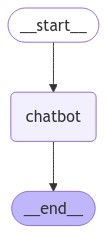

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.5)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Creating a name for the node and specifying the function.
# The messages that hte chatbot function returns will be added to the state
graph_builder.add_node("chatbot", chatbot)
# Add a starting point
graph_builder.add_edge(START, "chatbot")
# Add an ending point
graph_builder.add_edge("chatbot", END)
# Compile the graph
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [3]:
# Use streaming
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Goodbye!


In [17]:
# Note that when using invoke you must pass a dictionary where the key is  messages and the value is a list of dictionaries with the messages and includes role and content
graph.invoke({'messages':[{'role': 'user', 'content': 'tell me a joke' }]})

{'messages': [HumanMessage(content='tell me a joke', additional_kwargs={}, response_metadata={}, id='489e1ce6-64eb-4033-af63-f1479d2cb9f8'),
  AIMessage(content='Why did the scarecrow win an award?\n\nBecause he was outstanding in his field!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 11, 'total_tokens': 28, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None}, id='run-29a969e4-b3db-4a7f-ad58-263c2b3be67e-0', usage_metadata={'input_tokens': 11, 'output_tokens': 17, 'total_tokens': 28})]}

# Chatbot with Vector Look-Up

/Users/nadaa/Documents/code/py_innovations/srf_chatbot_v2/src/utils/qdrant_manager.py:51: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.1.2 and will be removed in 0.5.0. Use :class:`~QdrantVectorStore` instead.
  self.qdrant = Qdrant(


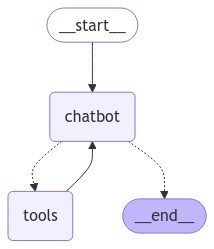

In [9]:

chatbot_instructions = """You are a helpful assistant for people that want to query and research the teachings of 
Paramhansa Yogananda and the Self-Realization Fellowship. You will only answer questions that are related to the teachings.
Provide compassionate and insightful responses that are grounded only in the context provided. 
Instructions:
- Ask follow-up questions if needed to clarify the question
- Query the vector database multiple times if the user query contains a question or questions that span multiple topics
- Include direct quotes whenever possible. 
- Provide a list of recommended reading when you output your answer
- Provide up to three suggestions for followup questions

"""

# Create the system message
system_message = SystemMessage(content=chatbot_instructions)

# Modify the LLM initialization
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.5)

memory = MemorySaver()
# Setup the state
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)


# Get vectorstore from qdrant
qdrant = qm.QdrantManager(collection_name="openai_large_chunks_1500char")
vectorstore = qdrant.get_vectorstore()

# Create my vector search tool
@tool
def vector_search(query: str, k: int = 5) -> list[Document]:
    """Search a vector database for passages from the teachings of Paramhansa Yogananda and other publications from the Self Realization Fellowship (SRF).
    The user has the option to specify the number of passages they want the search to return, otherwise the number of passages will be set to the default value."""
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})
    documents = retriever.invoke(query)
    return documents

# Create a list of tools and bind them to the LLM
tools=[vector_search]
llm_with_tools = llm.bind_tools(tools)

# Add the system message onto the llm
def chatbot(state: State):
    messages = [system_message] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

# Create and add a tool node
tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("chatbot", chatbot)

# Add a conditional edge wherein the chatbot can decide whether or not to go to the tools
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Recompile the graph with the new structure
graph = graph_builder.compile(checkpointer=memory)

# Visualize the updated graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [5]:
# Use streaming
config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [Document(metadata={'split_id_uuid': 'e0d78426-d586-464d-ab83-fa1b4c6d74f1', 'split_id_sequential': 282, 'chapter_name': 'Intuition Develops Through Meditation', 'publication_name': 'Journey to Self-Realization', '_id': '40595e45-e286-43da-adad-fb54de68b614', '_collection_name': 'openai_large_chunks_1500char'}, page_content='A joy and peace will strike your heart. When that comes, you know that you are communing with God. If you make the effort, you shall contact that Power. Give yourself that opportunity. You cannot succeed unless you try. If you spend your life in constant excitement, you will never know true happiness. Live simply and take life more easily. Happiness lies in giving yourself time to think and to introspect. Be alone once in a while, and remain more in silence. If the radio is going all the time, or other stimuli are constantly bombarding the senses, it truly affects the nerves and creates nervousness. And don’t think so much about reforming oth

In [10]:
config = {"configurable": {"thread_id": "1"}}
result = graph.invoke({"messages":[{"role": "user", "content": "Search the vector database on the importance of a true guru, return the full passages returned from the vector search verbatim and bold the most important quotes"}]}, config)


In [11]:
print(result['messages'][-1].content)

Here are the full passages from the teachings of Paramhansa Yogananda regarding the importance of a true guru, with key quotes emphasized:

1. **"It is admirable to lecture and teach good principles; but without possessing the qualifications of a real guru a teacher cannot redeem souls, nor should he presume to accept others as disciples until he himself has progressed far in his own Self-realization."** True gurus train first their inner selves in the theologically advanced school of intuition and God-communion in meditation. They spiritually baptize themselves in Spirit before they aspire to initiate others. They teach not for mundane gain or glory, but for the singular purpose of leading souls to God. A guru never seeks for himself the devotion and obedience of his disciples, but transfers that reverence to God. It is not necessary for a disciple to be in the company of the guru in order to receive his blessings. What is most important is to be spiritually in tune with the guru, for

In [15]:
config = {"configurable": {"thread_id": "1"}}
result = graph.invoke({"messages":[{"role": "user", "content": "Summarize in a nice paragraph format what yogananda says about introspection. At the end of the summary provide supporting quotes and resources."}]}, config)


In [16]:
print(result['messages'][-1].content)

Paramhansa Yogananda emphasizes the significance of introspection as a crucial practice for spiritual development and self-awareness. He describes introspection as a "wonderful mirror" that allows individuals to evaluate their thoughts and actions, promoting moral and spiritual growth. By reflecting on oneself, particularly in the light of a guru's wisdom, one can gain deeper insights and clarity. Yogananda advocates for accepting criticism as a sign of spiritual strength, encouraging individuals to learn from feedback and continuously strive for improvement. He also highlights the importance of deep thinking, asserting that concentrated reflection can lead to profound understanding and peace. Ultimately, Yogananda underscores personal responsibility, urging individuals to prioritize self-correction over the tendency to criticize others. This holistic approach to introspection is seen as essential on the path to self-realization and divine connection.

### Supporting Quotes:
- **"Intro

In [17]:
config = {"configurable": {"thread_id": "1"}}
result = graph.invoke({"messages":[{"role": "user", "content": "Find 20 passages on introspection and identify the subtopics that emerge."}]}, config)


In [18]:
print(result['messages'][-1].content)

Here are 20 passages on introspection from the teachings of Paramhansa Yogananda, along with the subtopics that emerge from these reflections:

1. **Introspection as Self-Judgment**: Yogananda describes introspection as a "wonderful mirror" for self-assessment, emphasizing the importance of judging oneself rather than others.

2. **Guidance from a Guru**: He highlights the value of seeing oneself through the lens of a wise guru, stating that their insights can lead to spiritual transformation.

3. **Strength in Criticism**: Yogananda notes that the ability to accept criticism is a sign of spiritual strength and encourages individuals to use criticism as a tool for self-improvement.

4. **Deep Thinking**: He advocates for deep thinking as a means to cultivate introspection, suggesting that it allows individuals to dive deeper into their thoughts and gain clarity and peace.

5. **Personal Responsibility**: Yogananda emphasizes the importance of personal responsibility in self-correction,

In [5]:
import gradio as gr
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
config = {"configurable": {"thread_id": "1"}}

# Define the chatbot function
# def chatbot(state):
#     llm = ChatOpenAI()
#     return {"messages": state["messages"] + [llm.invoke(state["messages"])]}

# # Create the graph
# graph = StateGraph()

# # Add the chatbot node
# graph.add_node("chatbot", chatbot)

# # Define the edges
# graph.add_edge(graph.START, "chatbot")
# graph.add_edge("chatbot", graph.END)

# # Compile the graph
# chain = graph.compile()

# Define the Gradio interface
def respond(message, history):
    # Format the history and new message into the expected structure
    formatted_messages = []
    for human, ai in history:
        formatted_messages.append(HumanMessage(content=human))
        if ai:  # AI might not have responded yet
            formatted_messages.append(AIMessage(content=ai))
    
    # Add the new message
    formatted_messages.append(HumanMessage(content=message))
    
    # Invoke the graph with properly formatted input
    result = graph.invoke({"messages": formatted_messages}, config)
    
    # Extract the assistant's response
    response = result["messages"][-1].content
    
    return response

# Create and launch the Gradio interface
gradio = gr.ChatInterface(respond)
gradio.launch(share=True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://5c55504e6a49d443ab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
